<a href="https://colab.research.google.com/github/molinacle/desafio_latam/blob/main/Desaf%C3%ADo_Latam_Prueba_Modelos_Avanzados_y_Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DESAFÍO LATAM - PRUEBA MODELOS AVANZADOS**
---

*   ALUMNO: SEBASTIÁN MOLINA
*   MODULO: MODELOS AVANZADOS Y REDES NEURONALES
*   CARRERA: DATA SCIENCE

#Detección de Noticias Falsas y Predicción de Popularidad de Artículos con Modelos Avanzados de Deep Learning

Este notebook abarca dos tareas principales:
- la detección de noticias falsas mediante redes neuronales recurrentes
- la predicción de popularidad de artículos con modelos de aprendizaje automático.

A continuación se detallan los pasos necesarios para cada tarea:

#### Importación de Librerías


In [108]:
# Instalación de librerías necesarias
!pip install gdown gensim tensorflow scikit-learn xgboost scikeras

In [110]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from gensim.models import KeyedVectors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from scikeras.wrappers import KerasRegressor
import util_bagging as ubagging
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import xgboost as xgb

---
## Paso 1: Carga y Exploración del Dataset de Noticias (news1.csv)

In [58]:
# Cargar el archivo CSV con manejo de delimitador, saltos de línea y comillas
file_path = 'news1.csv'

# Intentar cargar y limpiar el archivo
try:
    news_df = pd.read_csv(
        file_path,
        delimiter=',',
        quotechar='"',
        on_bad_lines='skip',
        engine='python'
    )
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

# Eliminar valores no deseados en la columna 'label'
valid_labels = ['FAKE', 'REAL']
news_df = news_df[news_df['label'].isin(valid_labels)]

# Eliminar valores nulos o no válidos en la columna 'text'
news_df = news_df.dropna(subset=['text'])
news_df = news_df[news_df['text'].apply(lambda x: isinstance(x, str))]

# Mapear las etiquetas de texto a valores numéricos
label_mapping = {'FAKE': 0, 'REAL': 1}
news_df['label'] = news_df['label'].map(label_mapping)

# Confirmar que los datos son consistentes
print(f"Dimensiones del dataset después de la limpieza: {news_df.shape}")
print(f"Conteo por clase en 'label':\n{news_df['label'].value_counts()}")

Dimensiones del dataset después de la limpieza: (6302, 5)
Conteo por clase en 'label':
label
1    3154
0    3148
Name: count, dtype: int64


In [59]:
# Visualización primeras filas del dataset
news_df.head()

,Unnamed: 0.1,Unnamed: 0,title,text,label
0,0,8476,You Can Smell Hillary’s Fear,A,0
1,2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
2,3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
3,4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1
4,5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",0


Ahora que el archivo se encuentra correctamente cargado y formateado vamos a realizar la división de los conjuntos de datos de entrenamiento y testeo.

In [60]:
# División del dataset
train_df, test_df = train_test_split(news_df, test_size=0.33, random_state=42, stratify=news_df['label'])

# Verificar las dimensiones
print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de prueba: {test_df.shape}")

Tamaño del conjunto de entrenamiento: (4222, 5)
Tamaño del conjunto de prueba: (2080, 5)


In [63]:
# Validar que no existan valores nulos o incorrectos después de la limpieza
assert train_df['text'].notnull().all(), "Hay valores nulos en 'text' en el conjunto de entrenamiento."
assert test_df['text'].notnull().all(), "Hay valores nulos en 'text' en el conjunto de prueba."
assert train_df['label'].notnull().all(), "Hay valores nulos en 'label' en el conjunto de entrenamiento."
assert test_df['label'].notnull().all(), "Hay valores nulos en 'label' en el conjunto de prueba."

In [64]:
# Exploración de frecuencias de palabras
tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts(train_df['text'])

# Generar secuencias y realizar el padding
max_len = 80
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# Asegurar que las dimensiones de entradas y etiquetas coincidan
assert len(train_sequences) == len(train_df['label']), "Las secuencias de entrenamiento no coinciden con las etiquetas."
assert len(test_sequences) == len(test_df['label']), "Las secuencias de prueba no coinciden con las etiquetas."

# Padding de secuencias
train_padded = pad_sequences(train_sequences, maxlen=max_len)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

# Confirmar alineación final
print(f"Dimensiones de train_padded: {train_padded.shape}")
print(f"Dimensiones de test_padded: {test_padded.shape}")

Dimensiones de train_padded: (4222, 80)
Dimensiones de test_padded: (2080, 80)


##Paso 2: Preparación del Embedding con Word2Vec Pre-entrenado

In [65]:
# Descargar y cargar Word2Vec pre-entrenado
url = 'https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK'
nombre_archivo = 'archivo.bin'
gdown.download(url, nombre_archivo, quiet=False)
word2vec_model = KeyedVectors.load_word2vec_format(nombre_archivo, binary=True)

# Creación de la matriz de embeddings
embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

Downloading...
From (original): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK
From (redirected): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK&confirm=t&uuid=4fdf3506-e743-4669-9836-91559fa588d3
To: /content/archivo.bin
100%|██████████| 3.64G/3.64G [01:28<00:00, 41.4MB/s]


##Paso 3: Modelo de Red Neuronal Recurrente (LSTM) para Clasificación

In [66]:
# Creación del modelo LSTM
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilación y entrenamiento
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_padded, train_df['label'], epochs=20, validation_split=0.2, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20


 11%|█         | 401M/3.64G [1:23:42<11:17:52, 79.8kB/s]


106/106 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.6241 - loss: 0.6390 - val_accuracy: 0.7053 - val_loss: 0.5382
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.7505 - loss: 0.5207 - val_accuracy: 0.7882 - val_loss: 0.4712
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - accuracy: 0.7978 - loss: 0.4447 - val_accuracy: 0.8107 - val_loss: 0.4143
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - accuracy: 0.8179 - loss: 0.4144 - val_accuracy: 0.8308 - val_loss: 0.4096
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.8358 - loss: 0.3772 - val_accuracy: 0.8260 - val_loss: 0.3834
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step - accuracy: 0.8411 - loss: 0.3683 - val_accuracy: 0.8272 - val_loss: 0.3886
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 246ms/step - accuracy: 0.8391 - loss: 0.3474 - val_accuracy: 0.8130 - val_loss: 0.3925
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.8662 - loss: 0.3186 - val

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step


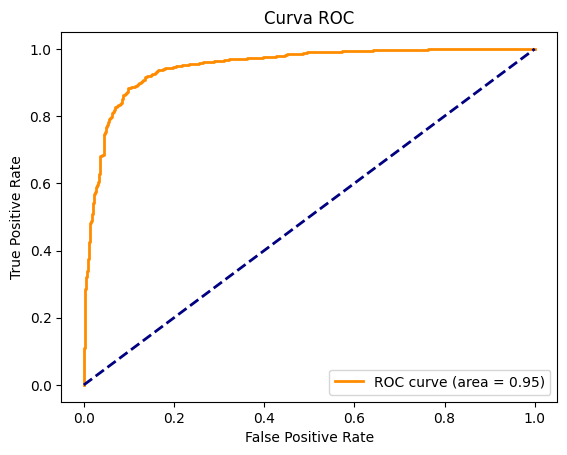

In [67]:
# Predicciones del modelo
preds = model.predict(test_padded)

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(test_df['label'], preds)
roc_auc = auc(fpr, tpr)

# Mostrar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Una ROC curve (area = 0.95) indica que el modelo tiene un excelente desempeño en la tarea de clasificación. Esto significa que el modelo puede distinguir muy bien entre las clases FAKE y REAL, logrando una gran precisión.

Vamos a analizar también otras métricas importantes para profundizar nuestro conocimiento del modelo.

In [69]:
# Convertir predicciones a binario usando un umbral
binary_preds = (preds > 0.6).astype(int)

# Generar el reporte de clasificación
print(classification_report(test_df['label'], binary_preds))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1039
           1       0.87      0.92      0.89      1041

    accuracy                           0.89      2080
   macro avg       0.89      0.89      0.89      2080
weighted avg       0.89      0.89      0.89      2080



El resultado de la matriz de confusión y el informe de clasificación muestra que el modelo tiene un desempeño balanceado y sólido para ambas clases (FAKE y REAL):

- Precision (Precisión): La proporción de predicciones positivas correctas frente a todas las predicciones positivas.
  - Para la clase 0 (FAKE): 0.91
  - Para la clase 1 (REAL): 0.87

- Recall (Sensibilidad): La proporción de casos positivos identificados correctamente.
  - Para la clase 0 (FAKE): 0.86
  - Para la clase 1 (REAL): 0.92

- F1-Score: La media armónica de precisión y recall, útil para evaluar el balance entre ambos.
  - Para la clase 0 (FAKE): 0.89
  - Para la clase 1 (REAL): 0.89

- Accuracy (Exactitud): 89% de las predicciones totales fueron correctas.
---
**Interpretación de los Resultados**

1. Balance Entre Clases:
  - Las métricas son bastante similares entre las clases 0 y 1, lo que indica que el modelo no está sesgado hacia una clase en particular.


2. Desempeño General:
  - Un F1-Score global de 0.89 es excelente y confirma que el modelo tiene un desempeño robusto, tanto en precisión como en recall.

##Paso 4: Predicciones y Análisis de Errores (news_pred.csv)

In [70]:
# Cargar y realizar predicciones en el dataset de prueba
news_pred_df = pd.read_csv('news_pred.csv')
news_pred_sequences = tokenizer.texts_to_sequences(news_pred_df['text'])
news_pred_padded = pad_sequences(news_pred_sequences, maxlen=max_len)

predictions = model.predict(news_pred_padded)
# Análisis de una predicción incorrecta o correcta

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


In [71]:
# Mapear las etiquetas de texto a valores numéricos en 'label'
news_pred_df['label'] = news_pred_df['label'].map({'FAKE': 0, 'REAL': 1})

# Añadir las predicciones binarizadas al dataframe
news_pred_df['predicted'] = (predictions > 0.5).astype(int)

# Identificar los casos donde el modelo se equivocó
misclassified = news_pred_df[news_pred_df['label'] != news_pred_df['predicted']]

# Mostrar casos mal clasificados
print("Casos mal clasificados:")
print(misclassified[['text', 'label', 'predicted']])

# Mostrar un caso específico si hay mal clasificados
if not misclassified.empty:
    print("\nEjemplo de caso mal clasificado:")
    print(misclassified.iloc[0][['text', 'label', 'predicted']])
else:
    print("No se encontraron casos mal clasificados.")

Casos mal clasificados:
Empty DataFrame
Columns: [text, label, predicted]
Index: []
No se encontraron casos mal clasificados.


Ok, en este caso no hay casos mal clasificados por el modelo, por lo que vamos a tener que analizar un caso correcto:

In [72]:
# Filtrar casos correctamente clasificados
correctly_classified = news_pred_df[news_pred_df['label'] == news_pred_df['predicted']]

# Verificar que hay casos correctamente clasificados
if not correctly_classified.empty:
    # Seleccionar un caso específico
    print("\nEjemplo de caso correctamente clasificado:")
    print(correctly_classified.iloc[0][['text', 'label', 'predicted']])
else:
    print("No se encontraron casos correctamente clasificados.")


Ejemplo de caso correctamente clasificado:
text         Gunmen stormed the offices of the satirical ne...
label                                                        1
predicted                                                    1
Name: 0, dtype: object


Este texto presenta varios conceptos clave que probablemente influyen en la predicción correcta del modelo. Aquí hay una explicación de cómo estos elementos pueden haber impactado:

1. **Términos Asociados a Temas Relevantes**

  El texto aborda temas de gran relevancia sociopolítica, como:
  - **Terrorismo:** Términos como "terror attack", "masked gunmen", "automatic weapons", y "Islamic State group" son indicadores fuertes de que la noticia tiene un alto impacto y relevancia.
  - **Libertad de expresión:** Palabras como "satirical newspaper", "caricatures", y "journalistic freedom" pueden asociarse a temas serios y reales en el contexto global.
  - **Liderazgo global:** Nombres de líderes como "Angela Merkel", "Francois Hollande", y "Barack Obama" son típicamente indicadores de noticias reales en artículos bien investigados.

  Estos términos probablemente coinciden con patrones aprendidos por el modelo a partir de las noticias reales (REAL) durante el entrenamiento.


2. **Estructura del Lenguaje**
  - **Detalles y Citas Específicas:**
  El texto incluye citas directas ("Allahu akbar!", "darkest day of the history of the French press"), descripciones de eventos específicos (como el ataque en las oficinas de Charlie Hebdo) y datos cronológicos ("Wednesday's attack", "Wednesday, killing 12 people"). Estas características suelen asociarse con noticias reales y verificadas.
  - **Neutralidad y Objetividad:** Aunque trata un tema emotivo, el lenguaje es mayormente neutral y descriptivo, lo que es típico en noticias de alta credibilidad.


3. **Contexto Histórico y Geopolítico**
  - La mención de eventos ampliamente reconocidos, como el ataque a Charlie Hebdo, proporciona un contexto que probablemente el modelo asocia con noticias reales. Este tipo de noticias es altamente reportado y documentado en fuentes confiables.


4. **Relación con Palabras Frecuentes en el Entrenamiento**
  - El modelo utiliza embeddings de Word2Vec, donde las palabras están representadas en un espacio vectorial que refleja sus relaciones semánticas. Las palabras relacionadas con terrorismo, libertad de prensa, y líderes mundiales probablemente están agrupadas cerca de términos que aparecen frecuentemente en noticias reales durante el entrenamiento.

En conclusión, el modelo puede haber haber predicho correctamente esta noticia como REAL dado que contiene palabras clave con alta relevancia contextual, una estructura descriptiva y objetiva del tema y por que contiene un contexto geopolítico reconocido.

##Paso 5: Carga y Limpieza de Datos (OnlineNewsPopularity.csv)

####Cargar el Archivo y Limpiar los Nombres de las Columnas

In [73]:
# Cargar el archivo CSV
mashable_df = pd.read_csv("OnlineNewsPopularity.csv")

# Quitar los espacios en blanco en los nombres de las columnas
mashable_df.columns = mashable_df.columns.str.strip()

# Verificar las primeras filas
print("Primeras filas del dataset:")
print(mashable_df.head())

# Verificar las dimensiones y los nombres de las columnas
print("\nDimensiones del dataset:", mashable_df.shape)
print("\nNombres de las columnas:")
print(mashable_df.columns)

Primeras filas del dataset:
                                                 url  timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...      731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...      731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...      731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...      731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/      731.0   

   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0            12.0             219.0         0.663594               1.0   
1             9.0             255.0         0.604743               1.0   
2             9.0             211.0         0.575130               1.0   
3             9.0             531.0         0.503788               1.0   
4            13.0            1072.0         0.415646               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  ...  \
0                  0.815385        4.0             

####Eliminar Columnas Irrelevantes

Identificar y eliminar columnas que no aporten información útil para la predicción (por ejemplo, URL o columnas redundantes).

In [74]:
# Columnas a eliminar
columns_to_drop = ['url']  # URL no aporta al modelo de predicción

# Eliminar las columnas
mashable_df = mashable_df.drop(columns=columns_to_drop)

# Verificar las dimensiones después de eliminar columnas
print("\nDimensiones del dataset después de eliminar columnas irrelevantes:", mashable_df.shape)


Dimensiones del dataset después de eliminar columnas irrelevantes: (39644, 60)


####Revisar Valores Ausentes

Inspeccionar si existen valores ausentes en el dataset y decidir cómo manejarlos.

In [75]:
# Revisar valores ausentes
missing_values = mashable_df.isnull().sum()
print("\nValores ausentes por columna:")
print(missing_values[missing_values > 0])

# Si hay valores ausentes, decidir qué hacer: eliminarlos o imputarlos
# Ejemplo: Eliminar filas con valores ausentes
mashable_df = mashable_df.dropna()

# Confirmar que no hay valores ausentes
print("\nValores ausentes después de la limpieza:")
print(mashable_df.isnull().sum().sum())


Valores ausentes por columna:
Series([], dtype: int64)

Valores ausentes después de la limpieza:
0


####Calcular Indicadores Estadísticos

Calcular estadísticas descriptivas para las variables numéricas.

In [76]:
# Seleccionar variables numéricas
numerical_features = mashable_df.select_dtypes(include=['float64', 'int64']).columns

# Calcular estadísticas descriptivas
stats = mashable_df[numerical_features].describe()

# Mostrar estadísticas descriptivas
print("\nIndicadores estadísticos para variables numéricas:")
print(stats)


Indicadores estadísticos para variables numéricas:
          timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
count  39644.000000    39644.000000      39644.000000     39644.000000   
mean     354.530471       10.398749        546.514731         0.548216   
std      214.163767        2.114037        471.107508         3.520708   
min        8.000000        2.000000          0.000000         0.000000   
25%      164.000000        9.000000        246.000000         0.470870   
50%      339.000000       10.000000        409.000000         0.539226   
75%      542.000000       12.000000        716.000000         0.608696   
max      731.000000       23.000000       8474.000000       701.000000   

       n_non_stop_words  n_non_stop_unique_tokens     num_hrefs  \
count      39644.000000              39644.000000  39644.000000   
mean           0.996469                  0.689175     10.883690   
std            5.231231                  3.264816     11.332017   
min          

**1. Observaciones Generales**

  - ***Cantidad de Datos:*** El dataset contiene 39,644 registros sin valores ausentes, lo cual es positivo para el modelado.

  - ***Variable Objetivo (shares):***
    - Media: 3,395 comparticiones, pero la desviación estándar es alta (11,627), lo que sugiere la presencia de valores extremos.
    - Mínimo y Máximo: Los valores varían desde 1 hasta 843,300, lo que indica una distribución muy sesgada.


**2. Variables Predictoras**

  - ***a. Términos Relacionados con el Contenido***
    - n_tokens_title y n_tokens_content:
      - El promedio de tokens en los títulos es 10.4, con un máximo de 23, indicando que la longitud de los títulos está controlada.
      - Los tokens en el contenido tienen una media de 546, pero alcanzan un máximo de 8474, lo cual puede incluir valores atípicos.

    - n_unique_tokens y n_non_stop_words:
      - Estas métricas muestran valores extremadamente altos en el máximo (701 y 1042 respectivamente), lo que probablemente sea ruido.

  - ***b. Medios y Recursos Visuales***
    - num_hrefs, num_imgs, num_videos:
      - Promedio: La mayoría de los artículos tienen alrededor de 10 enlaces y entre 4 imágenes.
      - Valores Máximos: Algunos artículos tienen hasta 304 enlaces, 128 imágenes, y 91 videos, lo cual podría distorsionar el análisis.

  - ***c. Polaridad y Subjetividad***
    - avg_positive_polarity y avg_negative_polarity:
      - La polaridad media de las palabras positivas es 0.33, mientras que la de las palabras negativas es -0.26.
      - Estos valores reflejan una ligera inclinación hacia contenidos neutrales, ya que las medianas están cerca de cero.
    - title_subjectivity y title_sentiment_polarity:
      - La subjetividad media en los títulos es baja (0.28), lo cual es consistente con artículos informativos.

**3. Observaciones Específicas**
  - ***Rangos Amplios:*** Muchas variables tienen un rango muy amplio (por ejemplo, shares, n_tokens_content, num_hrefs), lo que indica la necesidad de tratar valores extremos.
  - ***Distribuciones Sesgadas:*** La alta diferencia entre la media y los valores máximos en variables como shares o num_hrefs sugiere que estas variables están sesgadas hacia valores atípicos.

##Paso 6: Análisis y Eliminación de Outliers en shares

####Identificar y Eliminar Outliers en shares

Primero, identificamos outliers en la variable objetivo shares usando el rango intercuartílico (IQR) y eliminamos esos valores.

In [77]:
# Cálculo del rango intercuartílico (IQR)
Q1 = mashable_df['shares'].quantile(0.25)
Q3 = mashable_df['shares'].quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Limite inferior: {lower_bound}, Limite superior: {upper_bound}")

# Filtrar datos dentro del rango
mashable_no_outliers = mashable_df[(mashable_df['shares'] >= lower_bound) & (mashable_df['shares'] <= upper_bound)]

print(f"Datos originales: {len(mashable_df)}, Datos sin outliers: {len(mashable_no_outliers)}")

Limite inferior: -1835.0, Limite superior: 5581.0
Datos originales: 39644, Datos sin outliers: 35103


####Visualizar la Distribución de shares con y sin Outliers
Graficar la distribución antes y después de eliminar los outliers.

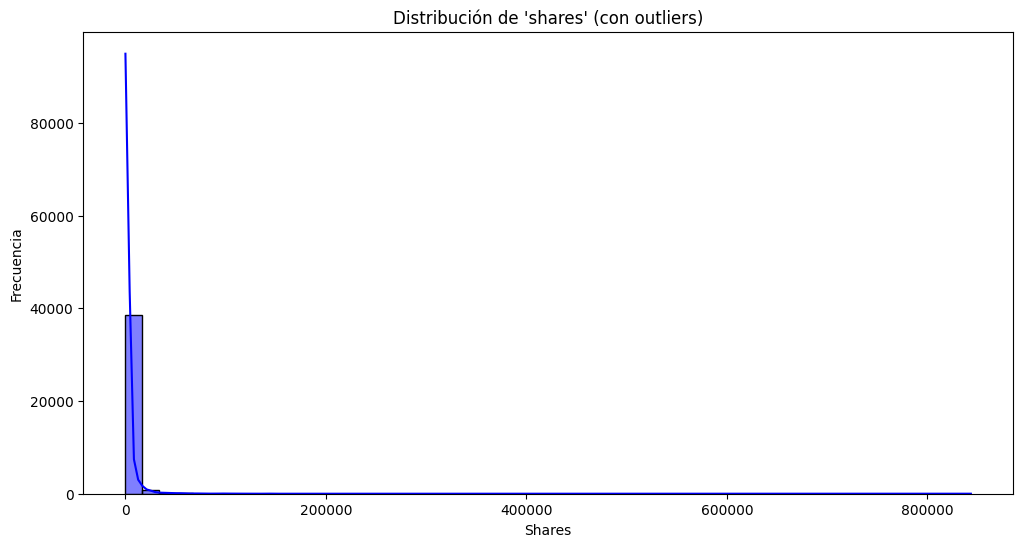

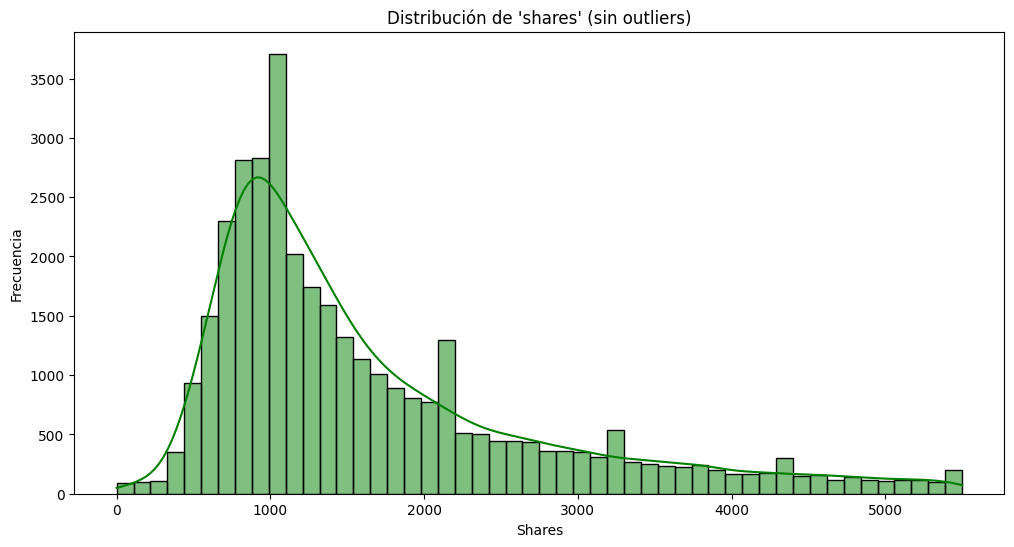

In [78]:
# Distribución original
plt.figure(figsize=(12, 6))
sns.histplot(mashable_df['shares'], bins=50, kde=True, color='blue')
plt.title("Distribución de 'shares' (con outliers)")
plt.xlabel("Shares")
plt.ylabel("Frecuencia")
plt.show()

# Distribución sin outliers
plt.figure(figsize=(12, 6))
sns.histplot(mashable_no_outliers['shares'], bins=50, kde=True, color='green')
plt.title("Distribución de 'shares' (sin outliers)")
plt.xlabel("Shares")
plt.ylabel("Frecuencia")
plt.show()

####Calcular y Graficar las Correlaciones
Calcular las correlaciones entre las variables numéricas y mostrar gráficamente las correlaciones antes de eliminar variables con alta correlación.

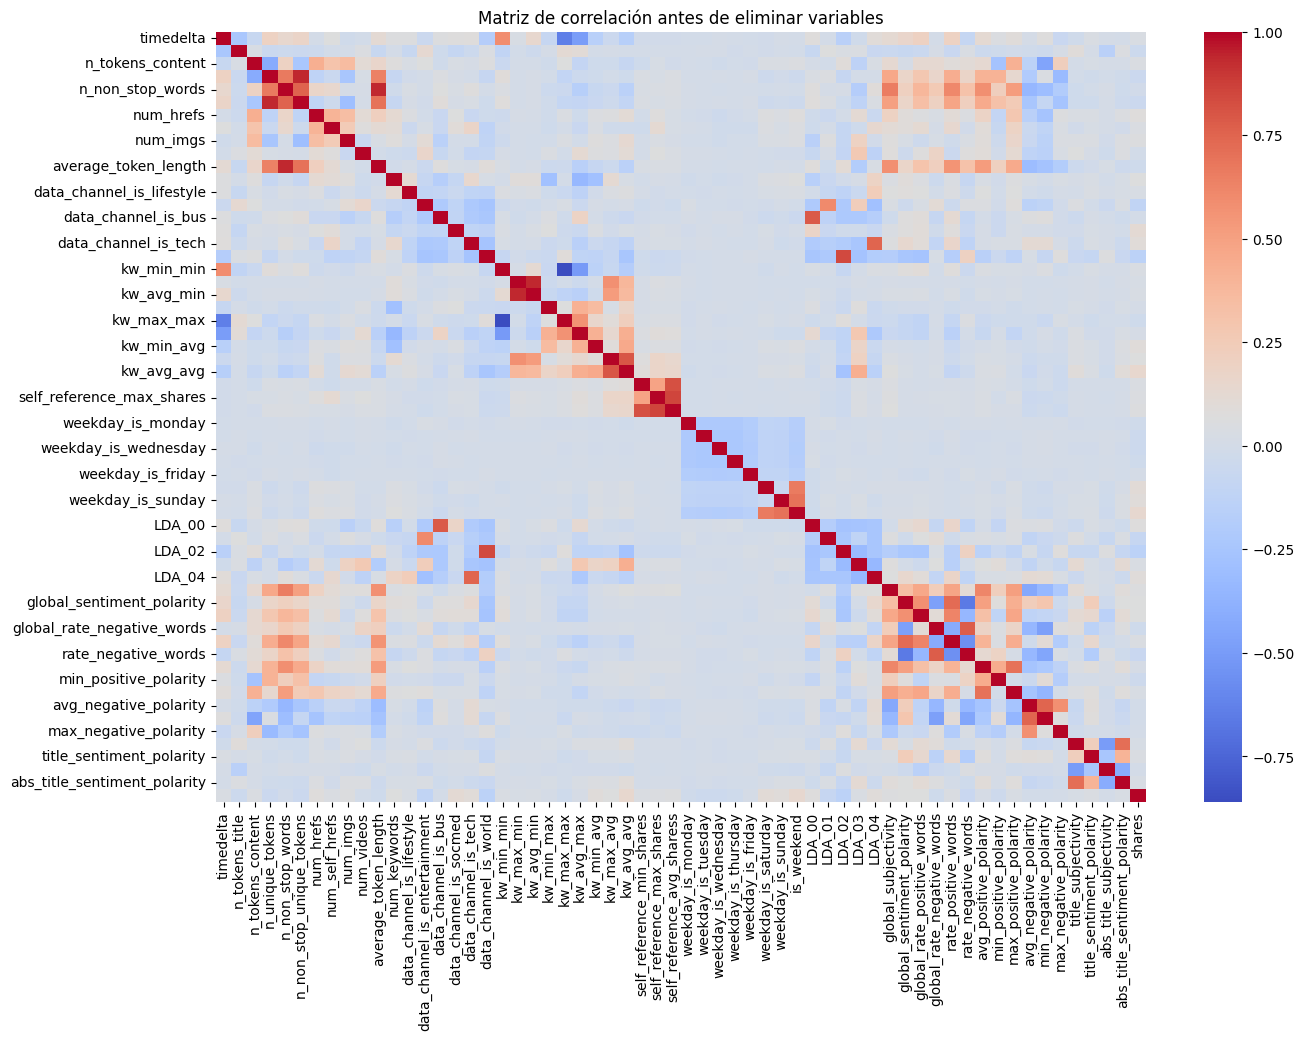

In [79]:
# Calcular la matriz de correlación
correlation_matrix = mashable_no_outliers.corr()

# Mostrar la matriz de correlación como un heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Matriz de correlación antes de eliminar variables")
plt.show()

####Identificar Pares de Variables con Correlación Alta (> 0.7)
Listar las variables con correlación alta (en valor absoluto).

In [80]:
# Identificar pares con correlación mayor a 0.7
high_corr_pairs = []

for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Mostrar pares con alta correlación
print("Pares con alta correlación (> 0.7):")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} y {var2}: {corr:.2f}")

Pares con alta correlación (> 0.7):
n_unique_tokens y n_non_stop_unique_tokens: 0.94
n_non_stop_words y n_non_stop_unique_tokens: 0.76
n_non_stop_words y average_token_length: 0.94
data_channel_is_bus y LDA_00: 0.78
data_channel_is_tech y LDA_04: 0.75
data_channel_is_world y LDA_02: 0.84
kw_min_min y kw_max_max: -0.86
kw_max_min y kw_avg_min: 0.93
kw_max_avg y kw_avg_avg: 0.80
self_reference_min_shares y self_reference_avg_sharess: 0.82
self_reference_max_shares y self_reference_avg_sharess: 0.86
weekday_is_sunday y is_weekend: 0.70
global_sentiment_polarity y rate_positive_words: 0.73
global_rate_negative_words y rate_negative_words: 0.78
avg_negative_polarity y min_negative_polarity: 0.75
title_subjectivity y abs_title_sentiment_polarity: 0.72


####Eliminar Variables con Alta Correlación
Eliminar una variable de cada par con correlación alta, preferentemente la menos significativa.

In [81]:
# Variables seleccionadas para eliminar (basado en los pares encontrados)
variables_to_drop = ['n_non_stop_words', 'kw_avg_min', 'LDA_04']  # Ejemplo, ajusta según el análisis previo

# Eliminar variables seleccionadas
mashable_no_outliers = mashable_no_outliers.drop(columns=variables_to_drop)

print(f"Variables eliminadas: {variables_to_drop}")
print(f"Dimensiones después de la eliminación: {mashable_no_outliers.shape}")

Variables eliminadas: ['n_non_stop_words', 'kw_avg_min', 'LDA_04']
Dimensiones después de la eliminación: (35103, 57)


####Graficar Correlaciones Después de Eliminar Variables
Mostrar la matriz de correlación después de eliminar las variables.

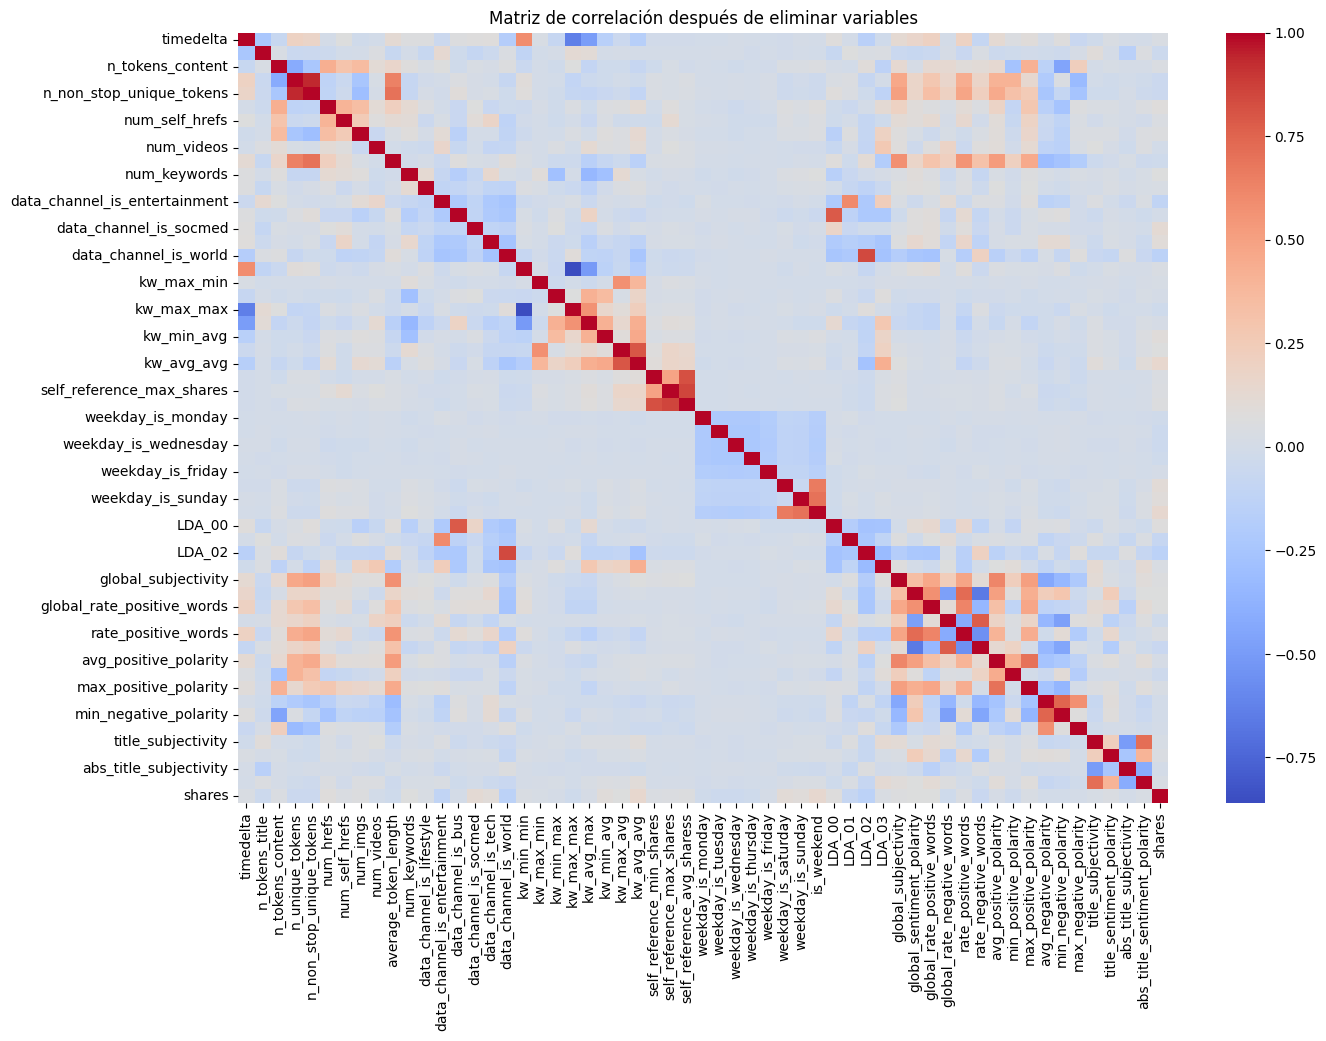

In [82]:
# Calcular nueva matriz de correlación
new_correlation_matrix = mashable_no_outliers.corr()

# Graficar la nueva matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(new_correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Matriz de correlación después de eliminar variables")
plt.show()

##Paso 7: División y Normalización de los Datos

####Seleccionar Cuatro Variables Numéricas y Analizar su Distribución
Seleccionaremos cuatro variables representativas para analizar su distribución.

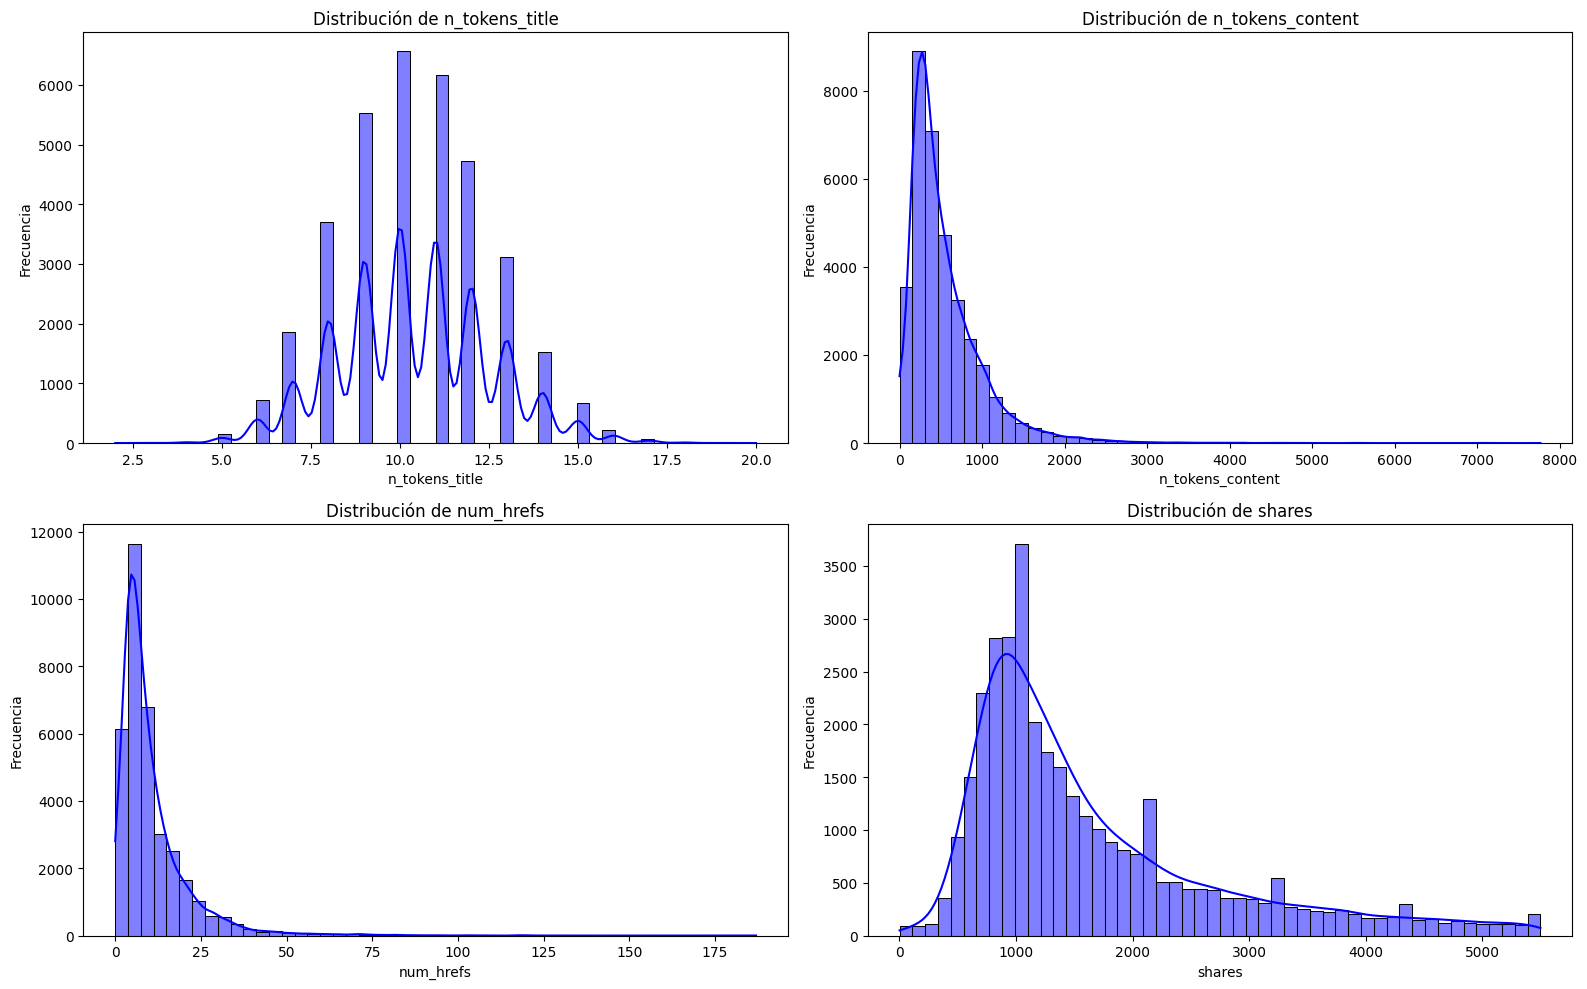

In [83]:
# Seleccionar cuatro variables para analizar su distribución
selected_variables = ['n_tokens_title', 'n_tokens_content', 'num_hrefs', 'shares']

# Graficar las distribuciones de las variables seleccionadas
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
for i, var in enumerate(selected_variables, 1):
    plt.subplot(2, 2, i)
    sns.histplot(mashable_no_outliers[var], bins=50, kde=True, color='blue')
    plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

####Normalizar Todas las Variables Numéricas
Normalizamos todas las variables numéricas para que tengan valores en un rango similar, lo que es útil para muchos algoritmos de aprendizaje automático.

In [85]:
# Seleccionar solo variables numéricas
numerical_features = mashable_no_outliers.select_dtypes(include=['float64', 'int64']).columns

# Normalizar las variables numéricas
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(mashable_no_outliers[numerical_features])

# Crear un nuevo DataFrame con los datos normalizados
normalized_df = pd.DataFrame(normalized_data, columns=numerical_features)

print("\nPrimeras filas del dataset normalizado:")
print(normalized_df.head())


Primeras filas del dataset normalizado:
   timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
0        1.0        0.555556          0.028207         0.663594   
1        1.0        0.388889          0.032844         0.604743   
2        1.0        0.388889          0.027177         0.575130   
3        1.0        0.388889          0.068393         0.503788   
4        1.0        0.611111          0.138073         0.415646   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  num_videos  \
0                  0.815385   0.021390        0.017241  0.007812         0.0   
1                  0.791946   0.016043        0.008621  0.007812         0.0   
2                  0.663866   0.016043        0.008621  0.007812         0.0   
3                  0.665635   0.048128        0.000000  0.007812         0.0   
4                  0.540890   0.101604        0.163793  0.156250         0.0   

   average_token_length  ...  min_positive_polarity  max_positive_polarity 

####Dividir los Datos en Entrenamiento y Prueba
Dividimos los datos en conjuntos de entrenamiento y prueba (33% para prueba).

In [86]:
# Separar características y variable objetivo
X = normalized_df.drop(columns=['shares'])  # Características
y = normalized_df['shares']  # Variable objetivo

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Verificar las dimensiones
print("\nTamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (23519, 56)
Tamaño del conjunto de prueba: (11584, 56)


##Paso 8: Entrenamiento de Modelo Random Forest

####Configurar la Búsqueda de Grilla
Usamos GridSearchCV para realizar la búsqueda de los mejores hiperparámetros.

In [88]:
# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Definir los parámetros de la búsqueda de grilla
param_grid = {
    'n_estimators': np.linspace(100, 300, 10, dtype=int),
    'max_depth': np.linspace(2, 15, 10, dtype=int),
    'max_features': ['sqrt', 'log2']
}

# Configurar la búsqueda de grilla con validación cruzada (5 folds)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("\nMejores hiperparámetros:")
print(grid_search.best_params_)

# Recuperar el mejor modelo
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

Mejores hiperparámetros:
{'max_depth': 15, 'max_features': 'log2', 'n_estimators': 211}


####Evaluar el Modelo con el Conjunto de Prueba
Usamos el modelo ajustado con los mejores hiperparámetros para realizar predicciones en el conjunto de prueba y evaluamos su desempeño.

In [89]:
# Realizar predicciones en el conjunto de prueba
y_pred = best_rf_model.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMétricas del modelo:")
print(f"MSE (Error Cuadrático Medio): {mse:.4f}")
print(f"R2 (Coeficiente de Determinación): {r2:.4f}")


Métricas del modelo:
MSE (Error Cuadrático Medio): 0.0342
R2 (Coeficiente de Determinación): 0.1428


####Visualizar Resultados
Graficar la relación entre las predicciones y los valores reales.

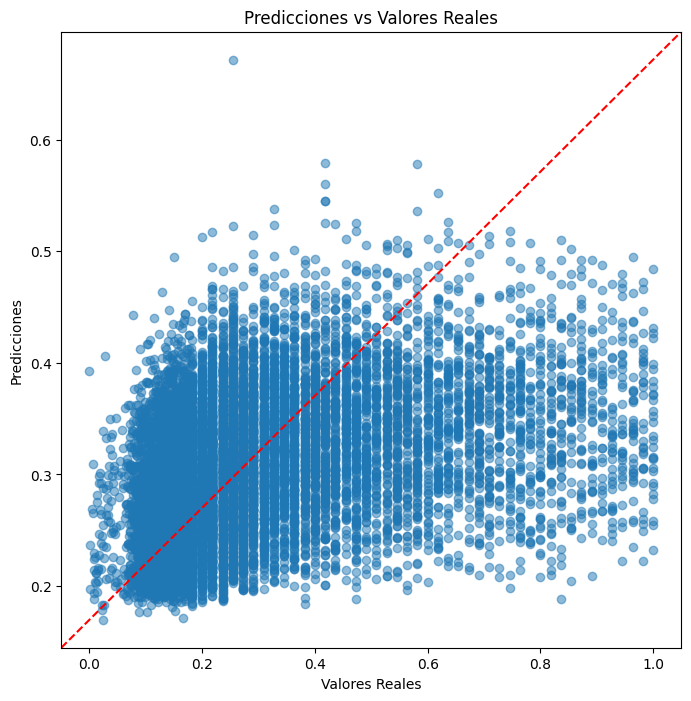

In [90]:
# Gráfica de predicciones vs valores reales
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], '--', color='red', transform=plt.gca().transAxes)
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

##Paso 9: Entrenamiento de Modelo Red Neuronal Fully Connected

####Crear el Modelo de Red Neuronal
Incluiremos al menos dos capas ocultas con más de 300 neuronas y regularización con Dropout.

In [91]:
# Crear el modelo Fully Connected
fc_model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),  # Primera capa oculta con 512 neuronas
    Dropout(0.3),  # Regularización Dropout
    Dense(256, activation='relu'),  # Segunda capa oculta con 256 neuronas
    Dropout(0.3),  # Regularización Dropout
    Dense(1, activation='linear')  # Capa de salida para regresión
])

# Compilar el modelo
fc_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


####Entrenar el Modelo
Entrenamos el modelo usando el conjunto de entrenamiento.

In [92]:
# Entrenar el modelo
history = fc_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 2/50
588/588 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 3/50
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 4/50
588/588 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0374 - val_mean_squared_error: 0.0374
Epoch 5/50
588/588 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 6/50
588/588 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 7/50
588/588 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss

####Evaluar el Modelo en el Conjunto de Prueba
Evaluamos el modelo en el conjunto de prueba y calculamos las métricas.

In [93]:
# Realizar predicciones en el conjunto de prueba
y_pred_fc = fc_model.predict(X_test)

# Calcular métricas de evaluación
mse_fc = mean_squared_error(y_test, y_pred_fc)
r2_fc = r2_score(y_test, y_pred_fc)

print("\nMétricas del modelo Fully Connected:")
print(f"MSE (Error Cuadrático Medio): {mse_fc:.4f}")
print(f"R2 (Coeficiente de Determinación): {r2_fc:.4f}")

362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Métricas del modelo Fully Connected:
MSE (Error Cuadrático Medio): 0.0362
R2 (Coeficiente de Determinación): 0.0923


####Visualizar Resultados
Graficamos las métricas y la relación entre las predicciones y los valores reales.

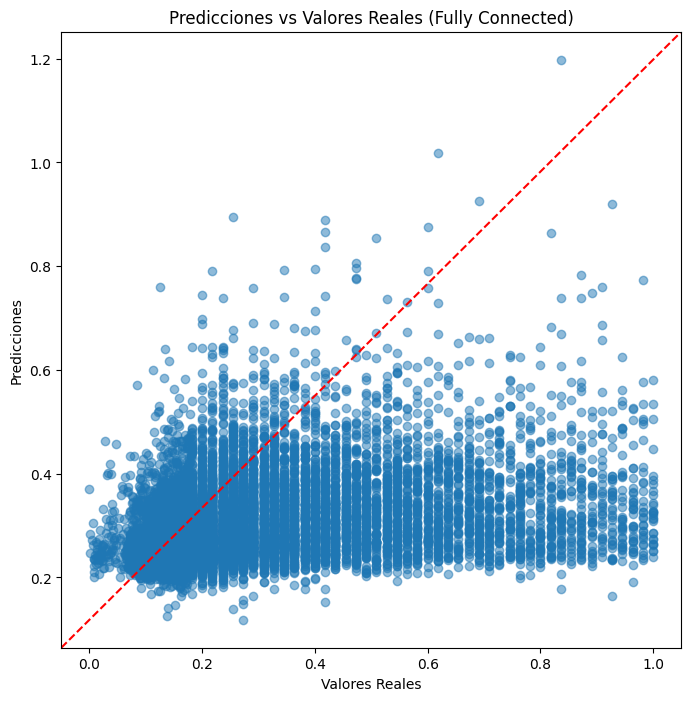

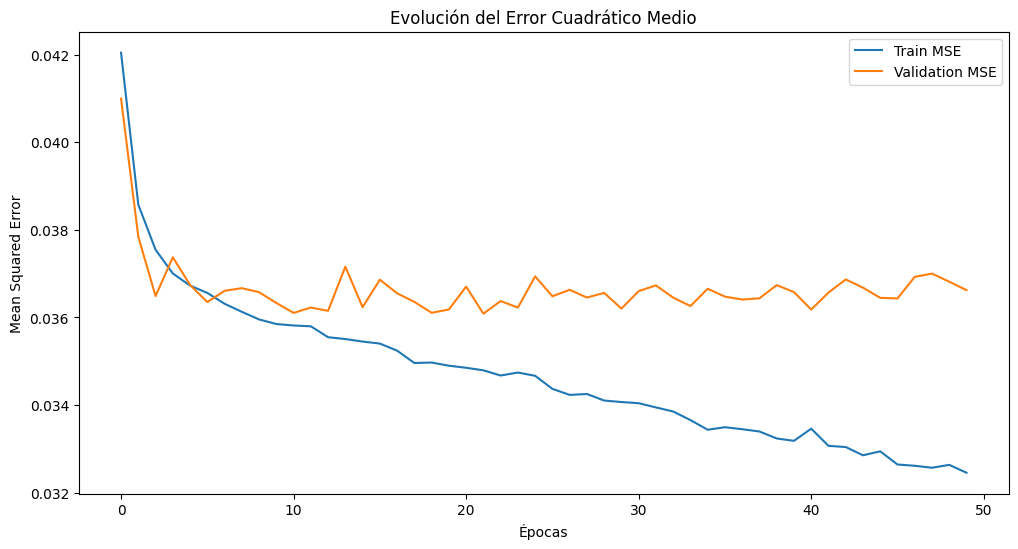

In [94]:
# Gráfica de predicciones vs valores reales
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_fc, alpha=0.5)
plt.plot([0, 1], [0, 1], '--', color='red', transform=plt.gca().transAxes)
plt.title("Predicciones vs Valores Reales (Fully Connected)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

# Graficar la evolución del error durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title("Evolución del Error Cuadrático Medio")
plt.xlabel("Épocas")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

##Paso 10: Entrenamiento de Modelo XGBoost

####Configurar la Búsqueda de Grilla
Configuramos los hiperparámetros y realizamos la búsqueda con validación cruzada de 5 folds.

In [100]:
# Definir los parámetros de la búsqueda de grilla
param_grid = {
    'n_estimators': [100, 120, 150, 200, 300],
    'learning_rate': [0.008, 0.07, 0.009, 0.01, 0.02],
    'subsample': np.linspace(0.05, 1, 5),
    'scale_pos_weight': np.linspace(0.8, 0.9, 2)
}

# Configurar la búsqueda de grilla con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("\nMejores hiperparámetros:")
print(grid_search.best_params_)

# Recuperar el mejor modelo
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits

Mejores hiperparámetros:
{'learning_rate': 0.02, 'n_estimators': 300, 'scale_pos_weight': 0.9, 'subsample': 0.7625}


####Evaluar el Modelo con el Conjunto de Prueba
Evaluamos el modelo ajustado en el conjunto de prueba.

In [101]:
# Realizar predicciones en el conjunto de prueba
y_pred_xgb = best_xgb_model.predict(X_test)

# Calcular métricas de evaluación
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nMétricas del modelo Extreme Gradient Boosting:")
print(f"MSE (Error Cuadrático Medio): {mse_xgb:.4f}")
print(f"R2 (Coeficiente de Determinación): {r2_xgb:.4f}")


Métricas del modelo Extreme Gradient Boosting:
MSE (Error Cuadrático Medio): 0.0336
R2 (Coeficiente de Determinación): 0.1578


####Importancia de las Características
Visualizamos la importancia de las características basada en el modelo ajustado.

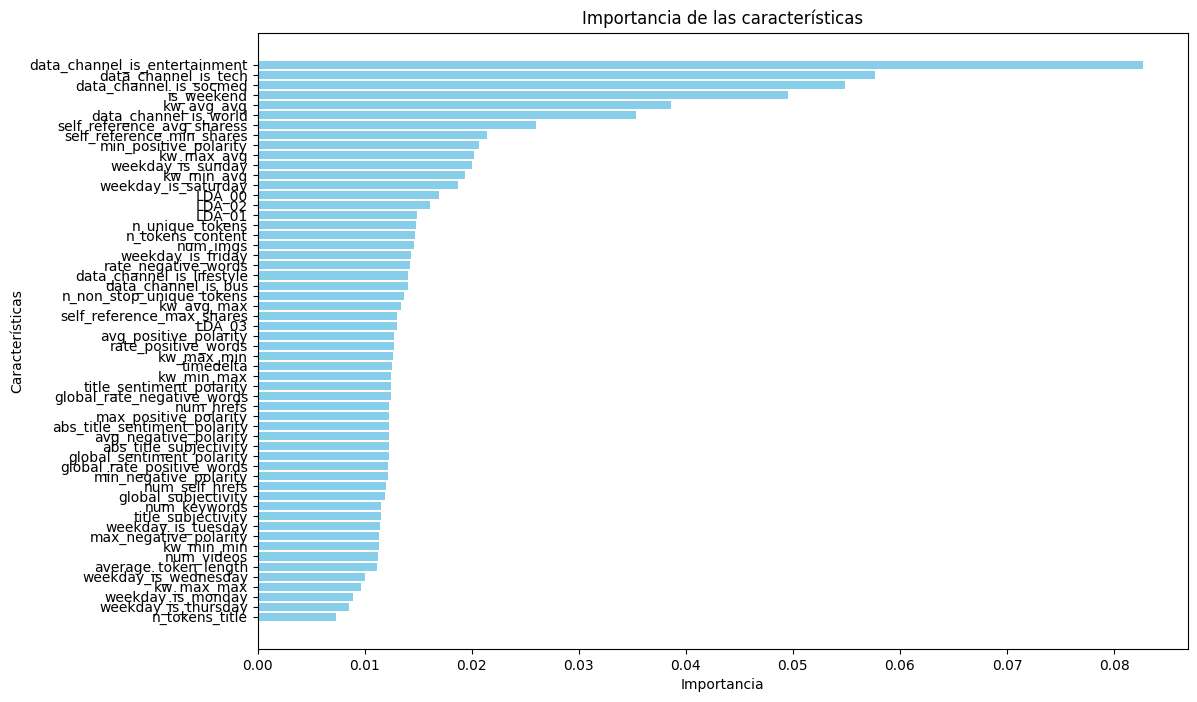

In [102]:
# Importancia de las características
importances = best_xgb_model.feature_importances_
features = X_train.columns

# Crear un DataFrame para organizar las características y su importancia
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características')
plt.gca().invert_yaxis()
plt.show()

####Visualizar Resultados
Graficamos la relación entre las predicciones y los valores reales.

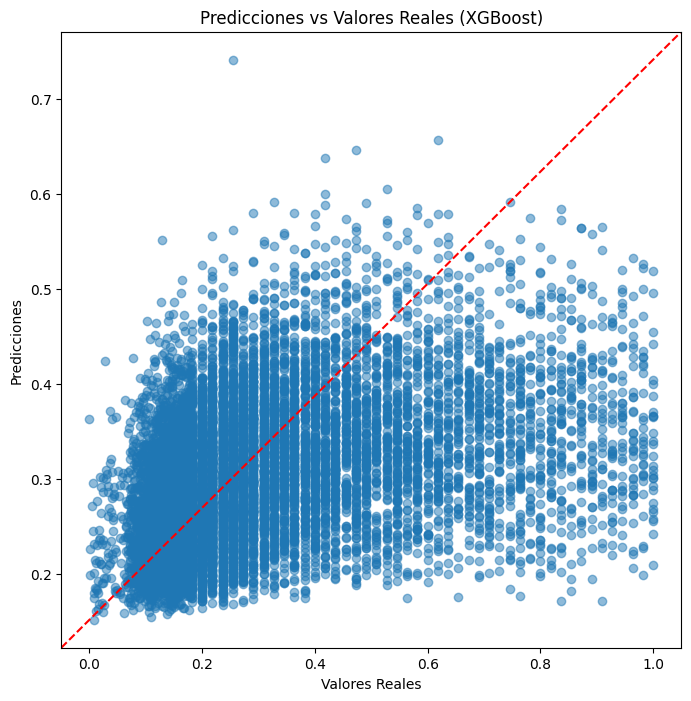

In [103]:
# Gráfica de predicciones vs valores reales
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([0, 1], [0, 1], '--', color='red', transform=plt.gca().transAxes)
plt.title("Predicciones vs Valores Reales (XGBoost)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

##Paso 11: Entrenamiento de Modelo de Bagging

####Importar y Preparar los Modelos
Utilizaremos tres modelos heterogéneos: RandomForestRegressor, XGBRegressor, y una red neuronal Fully Connected creada con Keras.

In [111]:
# Crear la red neuronal para incluir en el Bagging
def create_fc_model():
    model = Sequential([
        Dense(512, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Crear una lista de estimadores heterogéneos
estimators = [
    RandomForestRegressor(n_estimators=100, random_state=42),
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    KerasRegressor(build_fn=create_fc_model, epochs=10, batch_size=32, verbose=0)
]

####Implementar el Modelo Bagging
Usamos la función bagging_het para entrenar los modelos y obtener predicciones.

In [112]:
# Configuración del Bagging
T = 10  # Número de muestras bootstrap

# Entrenar el modelo Bagging
trained_models, yhat_test, yhat_out, idx_oob = ubagging.bagging_het(X_train, y_train, T, estimators, X_test)

# Resultados de Bagging
print("Predicciones del Bagging (mayoría de votos):")
print(yhat_out.head())

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using 

Predicciones del Bagging (mayoría de votos):
0    0.311033
1    0.154293
2    0.201190
3    0.314692
4    0.174234
Name: yhat, dtype: float64


####Evaluar el Modelo Bagging
Evaluamos el desempeño del modelo Bagging en el conjunto de prueba.

In [113]:
# Calcular métricas
mse_bagging = mean_squared_error(y_test, yhat_out)
r2_bagging = r2_score(y_test, yhat_out)

print("\nMétricas del modelo Bagging:")
print(f"MSE (Error Cuadrático Medio): {mse_bagging:.4f}")
print(f"R2 (Coeficiente de Determinación): {r2_bagging:.4f}")


Métricas del modelo Bagging:
MSE (Error Cuadrático Medio): 0.0395
R2 (Coeficiente de Determinación): 0.0113


####Comparar Resultados con Otros Modelos
Creamos un DataFrame para comparar las métricas de los modelos anteriores y del Bagging.

In [116]:
# Comparar métricas
results = pd.DataFrame({
    "Modelo": ["Random Forest", "XGBoost", "Fully Connected", "Bagging"],
    "MSE": [mse, mse_xgb, mse_fc, mse_bagging],
    "R2": [r2, r2_xgb, r2_fc, r2_bagging]
})

print("\nComparación de Resultados:")
print(results)


Comparación de Resultados:
            Modelo       MSE        R2
0    Random Forest  0.034233  0.142800
1          XGBoost  0.033633  0.157813
2  Fully Connected  0.036248  0.092340
3          Bagging  0.039484  0.011305


##Análisis de Resultados

Con base en los resultados obtenidos:

| **Modelo**          | **MSE**    | **R2**     |
|----------------------|------------|------------|
| Random Forest        | 0.034233  | 0.142800   |
| XGBoost              | 0.033633  | 0.157813   |
| Fully Connected      | 0.036248  | 0.092340   |
| Bagging              | 0.039484  | 0.011305   |



**1. Mean Squared Error (MSE):**

  - **XGBoost** obtuvo el mejor desempeño en términos de error cuadrático medio (MSE) con un valor de 0.033633, seguido de Random Forest con 0.034233.
  - **Fully Connected** presentó un MSE ligeramente superior (0.036248), lo que indica que tuvo un rendimiento moderado pero menos eficiente que los modelos basados en árboles.
  - **Bagging**, aunque combina modelos heterogéneos, tiene el MSE más alto (0.039484). Esto podría deberse a la dificultad de ensamblar modelos con características muy diferentes.

**2. Coeficiente de Determinación (R2):**

  - **XGBoost** lidera nuevamente con un R2 de 0.157813, lo que sugiere que explica el 15.78% de la varianza de los datos. Aunque no es un ajuste excelente, es el mejor entre los modelos probados.
  - **Random Forest** se ubica en segundo lugar con un R2 de 0.142800, lo que muestra que también es capaz de capturar cierta parte de la varianza.
  - **Fully Connected** tiene un R2 de 0.092340, indicando que explica menos del 10% de la varianza. Esto puede deberse a que las redes neuronales no son ideales para conjuntos de datos donde predominan relaciones estructuradas y no lineales claras.
  - **Bagging** tiene el peor desempeño con un R2 de 0.011305, lo que indica que casi no logra capturar la varianza en los datos.
---
####Conclusiones

  1. **Modelos Basados en Árboles (XGBoost y Random Forest):**
    - Los modelos basados en árboles (XGBoost y Random Forest) sobresalen en este análisis. XGBoost, en particular, logra el mejor desempeño tanto en MSE como en R2, lo que lo convierte en el modelo más adecuado para este problema.
    - Estos modelos son efectivos para capturar patrones no lineales y manejar datos tabulares con alta dimensionalidad.

  2. **Red Neuronal (Fully Connected):**
    - Aunque la red neuronal Fully Connected tiene un desempeño aceptable, su MSE es mayor y su R2 más bajo en comparación con los modelos basados en árboles. Esto podría deberse a que no logra explotar relaciones estructurales presentes en los datos.
    - Las redes neuronales suelen requerir una mayor cantidad de datos y un ajuste fino de hiperparámetros para superar a los modelos basados en árboles en este tipo de tareas.

  3. **Bagging:**
    - El modelo de Bagging muestra el peor desempeño, con el mayor MSE y el R2 más bajo. Esto puede deberse a que los modelos ensamblados son demasiado heterogéneos, lo que dificulta la combinación efectiva de predicciones.
    - Una posible mejora sería ajustar los hiperparámetros de los modelos base o seleccionar modelos más complementarios.
---
####Recomendación
  - XGBoost es el modelo preferido para este problema, ya que logra el mejor equilibrio entre error y capacidad explicativa (MSE bajo y R2 más alto).